<a href="https://colab.research.google.com/github/kannankumar/jupyter-notebooks/blob/hindi-digit-gan/Hindi_Digits_Conditional_DCGAN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hindi Digits Conditional DCGAN (Keras)
### Generating Handwritten Hindi Digits


In this notebook, we train a conditional DCGAN in Keras to generate images from a subset of the Devanagiri Dataset. This dataset contains both characters and numerals in the Devanigiri script. We use only the numerals for our Hindi Digit classification.

And here are how the numeric digits(0-9) look like (first row), their pronounciation (second row) and the decimal equivalent (last row):
![](https://camo.githubusercontent.com/bbe642072a12037f51fb718b23b09826f3d36b5f/68747470733a2f2f692e696d6775722e636f6d2f436b34723375472e706e67)

-----
**Footnote**

This notebook is inspired from the book **GANs in Action** and it's accompanying [Notebooks](https://github.com/GANs-in-Action/gans-in-action/blob/master/chapter-8/Chapter_8_CGAN.ipynb)

## 0. Download Dataset and Extract Devanagiri Character Images
UCI Machine Learning Repository) hosts this dataset.
So I'll be downloading it from there.

In [0]:
%%bash
wget -q http://archive.ics.uci.edu/ml/machine-learning-databases/00389/DevanagariHandwrittenCharacterDataset.zip
unzip -q DevanagariHandwrittenCharacterDataset.zip

In [0]:
import fnmatch
import os
import shutil

root_dir='DevanagariHandwrittenCharacterDataset'

def count_characters(dir_path):
  print(dir_path, 'Directory Details:')
  counts = {dr: len(os.listdir(os.path.join(dir_path, dr))) for dr in sorted(os.listdir(dir_path))}
  print(counts)

# # Uncomment this line to see the number of examples in dataset
# # Each character has 1700 images in Train and 300 images in Test

# count_characters(os.path.join(root_dir, 'Train'))
# count_characters(os.path.join(root_dir, 'Test'))

In [3]:
# Copy the digit images only from the dataset
def move_images(src_dir, dst_dir):
  print('Copying contents from ', src_dir, ' Directory...')
  if not os.path.exists(dst_dir):
    os.mkdir(dst_dir)

  # loop through train dir
  for dr in os.listdir(src_dir):
    # match dr with "digit*"
    src_sub_dir = os.path.join(src_dir, dr)
    if os.path.isdir(src_sub_dir) and fnmatch.fnmatch(dr, 'digit*'):
          print(dr, end=", ")
          
          # copy directory if it matches 'digit*'
          dst_sub_dir = os.path.join(dst_dir, dr)
          shutil.copytree(src=src_sub_dir, dst=dst_sub_dir)
  print('Done!\n\n')
  
move_images(os.path.join(root_dir, 'Train'), 'train-digits')
move_images(os.path.join(root_dir, 'Test'), 'test-digits')

Copying contents from  DevanagariHandwrittenCharacterDataset/Train  Directory...
digit_9, digit_3, digit_4, digit_2, digit_7, digit_6, digit_1, digit_5, digit_0, digit_8, Done!


Copying contents from  DevanagariHandwrittenCharacterDataset/Test  Directory...
digit_9, digit_3, digit_4, digit_2, digit_7, digit_6, digit_1, digit_5, digit_0, digit_8, Done!




Clean up dataset artifacts that we won't need anymore.

In [0]:
!rm -rf DevanagariHandwrittenCharacterDataset
!rm DevanagariHandwrittenCharacterDataset.zip

## 1. Load required packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras

Using TensorFlow backend.


In [0]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Reshape, Multiply, Concatenate, Embedding
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator

## 2. Load Images from Directory

In [0]:
# Input dimensions

img_width = 32
img_height = 32
img_channels = 1

img_shape = (img_width, img_height, img_channels)

z_dim = 100
batch_size = 32
num_classes = 10

In [8]:
# create a data generator
datagen = ImageDataGenerator()

# load and iterate training dataset
train_it = datagen.flow_from_directory('train-digits',
                                       color_mode='grayscale',
                                       target_size=(img_width,img_height), 
                                       batch_size=batch_size)

Found 17000 images belonging to 10 classes.


## 3. Visualize the Training Images

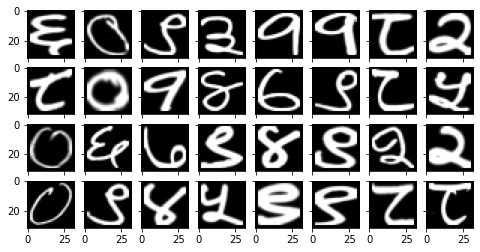

In [9]:
num_cols = 8
num_rows = 4

train_iter = iter(train_it)
images, labels = next(train_iter)
images = images/ 255
images = images * 2 -1
images = (images + 1) * 0.5
fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols,num_rows), sharex=True, sharey=True)

cnt = 0

for r in range(num_rows):
  for c in range(num_cols):
    ax[r][c].imshow(images[cnt, :, :, 0], cmap='gray')
    # ax[r][c].set_title(labels[cnt])
    cnt += 1


## 4. Define the Model Architecture

### 4.1. Generator

In [0]:
def build_generator(z_dim):
  model = Sequential()

  #100 -> 8x8x256
  model.add(Dense(8*8*256, input_dim=z_dim))
  model.add(Reshape((8,8,256)))
  
  # 8x8x256 -> 16x16x128
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 16x16x128 -> 16x16x64
  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 16x16x64 -> 32x32x1
  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
  model.add(Activation('tanh'))  

  return model

In [0]:
def build_cgan_generator(z_dim):
  z = Input(shape=(z_dim,))
  label = Input(shape=(1,), dtype='int32')

  label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
  label_embedding = Flatten()(label_embedding)

  joined_representation = Multiply()([z,label_embedding])

  generator = build_generator(z_dim)
  conditioned_img = generator(joined_representation)

  return Model([z,label],conditioned_img)

### 4.2. Discriminator

In [0]:
def build_discriminator(img_shape):
  model = Sequential()

  #32x32x1 -> 16x16x64
  model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', 
                   input_shape=(img_shape[0], img_shape[1], img_shape[2]+1)))
  model.add(LeakyReLU(alpha=0.1)) 

  #16x16x64 -> 8x8x64
  model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1)) 

  # 8x8x64 -> 4x4x128
  model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 4x4x128 -> 4*4*128
  model.add(Flatten())

  # 4*4*128 -> 1
  model.add(Dense(1, activation='sigmoid'))
  
  return model

In [0]:
def build_cgan_discriminator(img_shape):
  img = Input(shape=(img_shape))

  label = Input(shape=(1,), dtype='int32')
  label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
  label_embedding = Flatten()(label_embedding)
  label_embedding = Reshape(img_shape)(label_embedding)

  concatenated_input = Concatenate(axis=-1)([img, label_embedding])

  discriminator = build_discriminator(img_shape)
  classification = discriminator(concatenated_input)

  return Model([img, label], classification)

### 4.3. Full Conditional GAN model

In [0]:
def build_cgan(generator, discriminator):
  z = Input(shape=(z_dim,))
  label = Input(shape=(1,), dtype='int32')

  img = generator([z, label])
  classification = discriminator([img, label])

  return Model([z,label],classification)

## 5. Compile the Model

In [0]:
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_cgan_generator(z_dim)
discriminator.trainable = False

cgan = build_cgan(generator, discriminator)
cgan.compile(loss='binary_crossentropy', optimizer=Adam())

## 6. Training Loop

In [0]:
def train(iterations, batch_size, print_every, sample_every):

  # Create real and fake labels for a batch
  real_labels = np.ones((batch_size, 1))
  fake_labels = np.zeros((batch_size, 1))

  iteration = 0

  for train_images, train_labels in train_it:

    if len(train_images) == batch_size :
      
      # Preproecess data to have range [-1,1]
      train_images = train_images / 255      # range 0 to 1
      train_images = train_images*2 - 1  

      # The generator expects a single value class number
      train_labels = np.argmax(train_labels, axis=-1)
      #**********************************#
      #       Train Discriminator        #
      #**********************************#

      # Take a batch of random noise vectors
      z = np.random.normal(0,1, (batch_size, z_dim))

      # Generate a batch of fake images
      gen_imgs = generator.predict([z, train_labels])

      d_loss_real = discriminator.train_on_batch([train_images, train_labels], real_labels)
      d_loss_fake = discriminator.train_on_batch([gen_imgs, train_labels], fake_labels)
      d_loss = np.add(d_loss_real, d_loss_fake) * 0.5

      #**********************************#
      #         Train Generator          #
      #**********************************#
      
      # Take a batch of random noise vectors
      z = np.random.normal(0,1,(batch_size, z_dim))

      # Take a batch of random labels
      labels = np.random.randint(0,num_classes, batch_size).reshape(-1,1)

      # Generate a batch of fake images
      g_loss = cgan.train_on_batch([z, labels], real_labels)

      #**********************************#
      #       Iteration Metrics          #
      #**********************************#
      iteration_checkpoints.append(iteration+1)
      losses.append((d_loss[0], g_loss))
      accuracies.append(d_loss[1]*100)

      #**********************************#
      #     Aggregated Step Metrics      #
      #**********************************#
      if (iteration+1) % print_every == 0:
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % \
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))
      if (iteration+1) % sample_every == 0:
        sample_images(generator)
        gen_checkpoints.append(generator) 
      
      
      if iteration == iterations:
        break
      else:
        iteration += 1

In [0]:
def sample_images(generator, rows=2, cols=5, zoom_level=1):
  z = np.random.normal(0,1, (rows * cols, z_dim))
  labels = np.arange(0,num_classes).reshape(-1,1)
   
  gen_imgs = generator.predict([z,labels])
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig,axs = plt.subplots(rows, cols, figsize=(cols*zoom_level, rows*zoom_level),
                         sharey=True, sharex=True)
  
  cnt = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
      axs[i,j].axis('off')
      axs[i,j].set_title("Digit: %d"% labels[cnt])
      
      cnt += 1

Test the generator before training.  

If there is overlapping kernels which can cause checkerboard artifacts, this can be detected even without a trained generator.

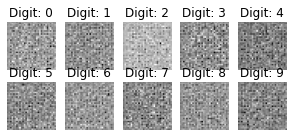

In [18]:
sample_images(generator)

## 7. Training the GAN

In [0]:
losses = []
accuracies = []
iteration_checkpoints = []
gen_checkpoints = []

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1000 [D loss: 0.001413, acc.: 100.00%] [G loss: 0.115857]
2000 [D loss: 0.021558, acc.: 98.44%] [G loss: 5.670769]
3000 [D loss: 0.272163, acc.: 82.81%] [G loss: 4.120982]
4000 [D loss: 0.037794, acc.: 100.00%] [G loss: 4.714747]
5000 [D loss: 0.026922, acc.: 100.00%] [G loss: 5.594457]
6000 [D loss: 0.028281, acc.: 100.00%] [G loss: 2.380921]
7000 [D loss: 0.093516, acc.: 98.44%] [G loss: 4.671591]
8000 [D loss: 0.217665, acc.: 89.06%] [G loss: 3.361166]
9000 [D loss: 0.023817, acc.: 100.00%] [G loss: 5.482484]
10000 [D loss: 0.010076, acc.: 100.00%] [G loss: 5.880479]


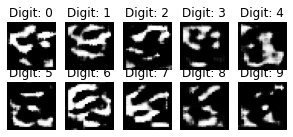

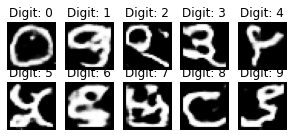

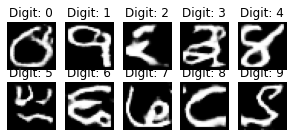

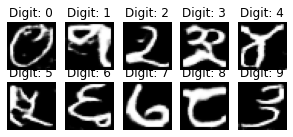

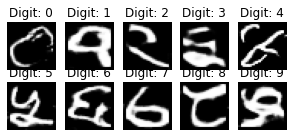

In [116]:
iterations = 10000
batch_size = 32
print_interval = 1000
sample_interval = 2000

train(iterations, batch_size, print_interval, sample_interval)

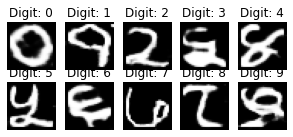

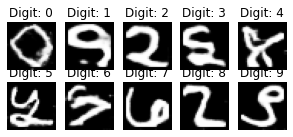

In [118]:
sample_images(generator)
sample_images(generator)

## 8. Saving the model

In [0]:
# Download Generator model
generator.save('hindi_digit_generator_model.h5')

# Download Discriminator model
discriminator.save('hindi_digit_discriminator_model.h5')

## 9. Generating samples

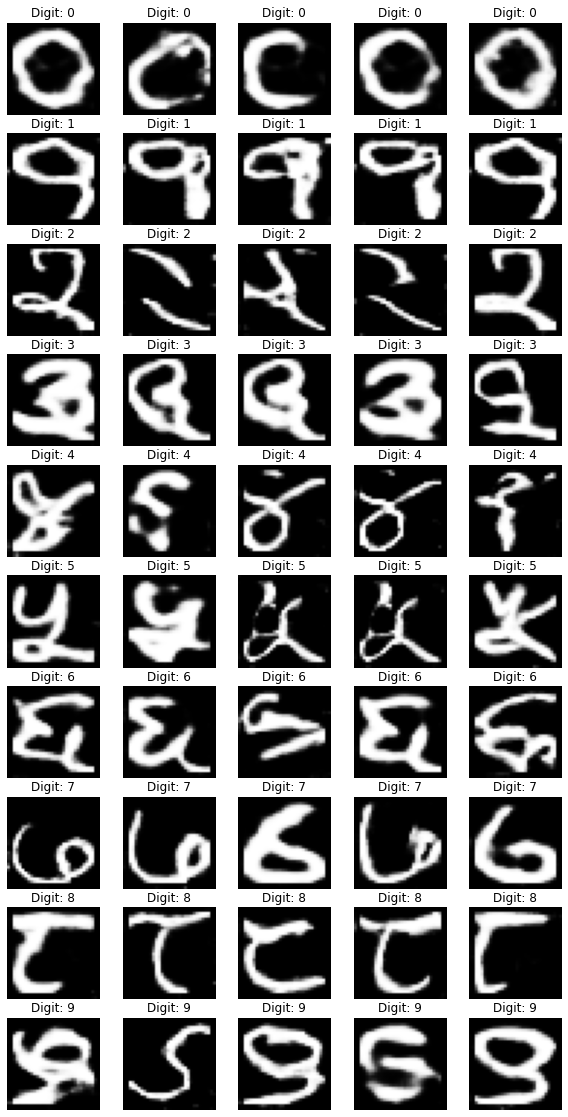

In [120]:
# Set grid dimensions
image_grid_rows = 10
image_grid_columns = 5

# Sample random noise
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# Get image labels to generate: 5 samples for each label
labels_to_generate = np.array([[i for j in range(5)] for i in range(10)])
labels_to_generate = labels_to_generate.flatten().reshape(-1, 1)

# Generate images from random noise
gen_imgs = generator.predict([z, labels_to_generate])

# Rescale image pixel values to [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows,
                        image_grid_columns,
                        figsize=(10, 20),
                        sharey=True,
                        sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output a grid of images
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title("Digit: %d" % labels_to_generate[cnt])  ## NEW
        cnt += 1